In [3]:
import gym
import torch
import sys
sys.path.append('..')  # Adds the upper directory to the python path.
from gym_env import ClipRewardWithBound, DoneOnLifeLoss, FireOnReset, MaxAndSkip, NoopReset, ObservationChannelFirst, PlayerIdAndActionMaskWrapper, ResizeAndGrayscaleFrame, ScaledFloatFrame, StackFrameAndAction, StackFrame


In [37]:
def create_atari_environment(
    env_name: str,
    seed: int = 1,
    frame_skip: int = 4,
    frame_stack: int = 2,
    screen_height: int = 96,
    screen_width: int = 96,
    noop_max: int = 30,
    max_episode_steps: int = 108000,
    terminal_on_life_loss: bool = False,
    clip_reward: bool = False,
    scale_obs: bool = False,
    output_actions: bool = False
) -> gym.Env:
    """
    Process gym env for Atari games according to the Nature DQN paper.

    Args:
        env_name: the environment name without 'NoFrameskip' and version.
        seed: seed the runtime.
        frame_skip: the frequency at which the agent experiences the game,
                the environment will also repeat action.
        frame_stack: stack n last frames.
        screen_height: height of the resized frame.
        screen_width: width of the resized frame.
        noop_max: maximum number of no-ops to apply at the beginning
                of each episode to reduce determinism. These no-ops are applied at a
                low-level, before frame skipping.
        max_episode_steps: maximum steps for an episode.
        terminal_on_life_loss: if True, mark end of game when loss a life, default off.
        clip_reward: clip reward in the range of [-1, 1], default off.
        scale_obs: scale the frame by devide 255, turn this on may require 4-5x more RAM when using experience replay, default off.

    Returns:
        preprocessed gym.Env for Atari games.
    """
    if 'NoFrameskip' in env_name:
        raise ValueError(f'Environment name should not include NoFrameskip, got {env_name}')

    env = gym.make(f'{env_name}NoFrameskip-v4')
    env.seed(seed)
    # env.reset(seed=seed)

    # Change TimeLimit wrapper to 108,000 steps (30 min) as default in the
    # litterature instead of OpenAI Gym's default of 100,000 steps.
    env = gym.wrappers.TimeLimit(env.env, max_episode_steps=None if max_episode_steps <= 0 else max_episode_steps)

    env = NoopReset(env, noop_max=noop_max)
    env = MaxAndSkip(env, skip=frame_skip)

    if terminal_on_life_loss:
        env = DoneOnLifeLoss(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireOnReset(env)
    if scale_obs:
        env = ScaledFloatFrame(env)
    if clip_reward:
        env = ClipRewardWithBound(env, 1.0)

    # The order is important as StackFrameAndAction expects channel first for Atari games.
    env = ObservationChannelFirst(env, True)
    if frame_stack > 1:
        env = StackFrame(env, frame_stack, True)

    env = PlayerIdAndActionMaskWrapper(env)
    if output_actions:
        return env, env.unwrapped.get_action_meanings()
    return env

In [38]:
env, actions = create_atari_environment('Breakout', screen_height=224, screen_width=224, output_actions=True)

In [39]:
actions

['NOOP', 'FIRE', 'RIGHT', 'LEFT']

In [40]:
obs = env.reset()
obs.shape

(6, 210, 160)

In [41]:
frame_1 = obs[:3, :, :]
frame_1_t = torch.tensor(frame_1, dtype=torch.float32, device="mps")
frame_1_t.shape


torch.Size([3, 210, 160])

In [42]:
import open_clip

model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')

(210, 160, 3)


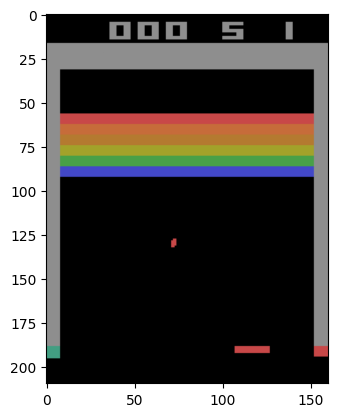

In [43]:
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np

i_f1 = frame_1.transpose(1, 2, 0)

print(i_f1.shape)

plt.imshow(frame_1.transpose(1, 2, 0) / 255)

image_1 = Image.fromarray(np.uint8(frame_1.transpose(1, 2, 0)))

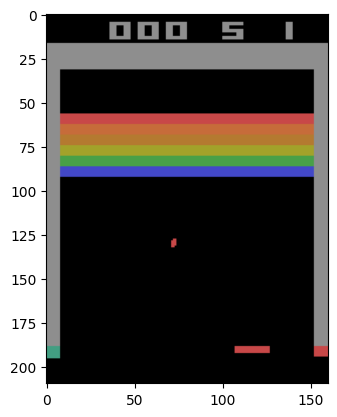

In [44]:
plt.imshow(image_1)

In [45]:
ref_image = preprocess(image_1)

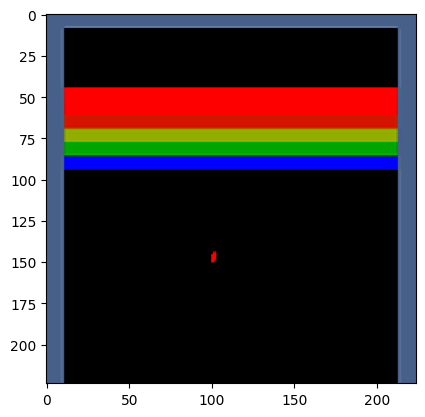

In [46]:
plt.imshow(ref_image.permute(1, 2, 0))

In [52]:
from torchvision.transforms.v2 import Normalize, ToImage, ToTensor, Compose, Resize
mean = (0.48145466, 0.4578275, 0.40821073)
std = (0.26862954, 0.26130258, 0.27577711)

normalize = Normalize(mean=mean, std=std)
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size(), device=tensor.device) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

transforms = Compose([
    ToImage(),
    Resize((224, 224), antialias=False),
    AddGaussianNoise(0., 0.01),
    Normalize(mean=mean, std=std),
    ToTensor()
])

image_man = transforms(frame_1_t.to("mps") / 255)

/Users/paul/dev/muzero/.venv/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, mps:0 and cpu!

In [53]:

diff = image_man - ref_image.to("mps")


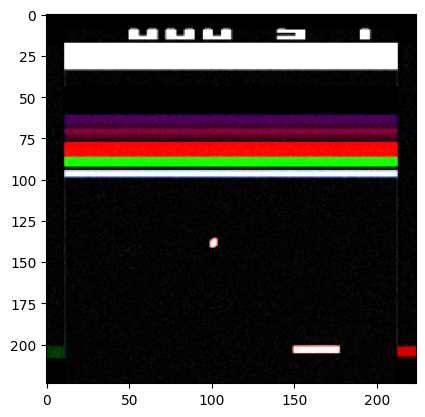

In [51]:
plt.imshow(diff.cpu().permute(1, 2, 0))